<h1><center>Laboratorio 9: Benchmark Estadístico con Reddit 🧮</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Pablo Badilla
- Auxiliar: Ignacio Meza D.
- Ayudante: Constanza Peña

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Francisca Solís
- Nombre de alumno 2: Javier Castro


### **Link de repositorio de GitHub:** `http://....`

# Temas a tratar

- Optimización de Código en Python.
- Utilización de librerías para medir el tiempo de ejecución de funciones.
- Métodos para optimizar el rendimiento de las funciones.

# Reglas:

- Fecha de entrega: 3/12/2021
- **Grupos de 2 personas**
- **Ausentes** deberán realizar la actividad solos. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

# Objetivos principales del laboratorio

- Obtener datos desde Reddit a partir de la librería `praw` y visualizar cuales post son más probables que sean puntuados positivamente.
- Aplicar un atajo estadístico para obtener la mean posterior de datos.
- Optimizar a través de librerías funciones.

#Importamos librerias utiles 😸

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%%capture
#!pip install praw
#!pip install line_profiler
#!pip install numba

import sys
import praw
import time
import numpy as np
import pandas as pd
from numba import jit
import plotly.express as px
from functools import lru_cache
from IPython.core.display import Image

# 1. Recomendando Posts de Subreddit

<p align="center">
  <img src="https://styles.redditmedia.com/t5_2rer8/styles/bannerBackgroundImage_xzrb6my122181.jpg">
</p>

Unos intrépidos alumnos del curso, quienes frecuentemente participan en subreddits y foros de reviews, se preguntan lo siguiente: ¿Podremos confiar que un post es bueno, si este tiene solamente 1 o 3 votos positivos?. los compañeros, creen que esto claramente no representa una opinión general, ya que estamos mucho menos seguros acerca de la verdadera proporción de votos a favor de los comentarios con pocos datos. ¿Pero cómo podemos obtener una representación más creíble para este problema?.

Lo señalado forma parte de un problema estadísticos, donde a través del cálculo de la posterior se puede conocer que tan probable es que un post sea bueno. Para efectos de este laboratorio, no se exige un conocimiento previo para resolver este problema, simplemente se deberá aplicar las ecuaciones presentadas más adelante (De igual forma si quedan interesados sobre el tema se les invita a tomar el ramo [CC6104](https://github.com/dccuchile/CC6104)).

## 1.1 Obtención de Subrredits y Análisis [1 Punto]

Para estudiar que tan probable es que un post sea positivo se comenzará cargando datos reales del subreddit chile desde reddit (si usted desea puede cambiar el subreddit a uno de su gusto). Para esto le proponemos la utilización de la función que aparece mas abajo, la que presenta un usuario ya creado por el equipo docente. Dese un tiempo para entender que hace cada parte de la función, visualizando que se obtiene de estas.

Revisada la función, utilice un **perfilador** para monitorear el tiempo y memoria que les toma a cada liena de código para ser ejecutada. Señale cuales son los procesos que mas tiempo consumen en la ejecución del Código, comentando si es posible mejorar el desempeño de la función.

**TO-DO:**
- [ ] Estudiar la función propuesta por el equipo docente.
- [ ] Estudiar los tiempos de ejecución del código a través de un perfilador.
- [ ] Estudiar la memoria ocupada por el código a través de un perfilador.
- [ ] Comente los resultados. ¿Qué lineas ocupan más memoria o más/menos tiempo?¿Por qué?

In [5]:
def praw_reddit(nombre_subreddit="chile", n_hot=1000):
    reddit = praw.Reddit(
        client_id="-w2hyFINxZ8T3g",
        client_secret="zGPCI4s3g6Ic6AsRi7vIpP0NoxbFdw",
        password="ClasesMDS7202",
        user_agent="Clases",
        username="DocenciaDataScience",
        check_for_async=False,
    )
    subreddit = reddit.subreddit(nombre_subreddit)

    votes, post, url = {}, {}, {}
    top_submissions = list(subreddit.hot(limit=n_hot))
    for it, top_n in enumerate(range(50, len(top_submissions), 50)):
        top_n_submissions = top_submissions[:top_n]
        upvotes, downvotes, url[it], post[it] = [], [], [], []

        for submission in top_n_submissions:
            try:
                ratio = submission.upvote_ratio
                ups = int(
                    round((ratio * submission.score) / (2 * ratio - 1))
                    if ratio != 0.5
                    else round(submission.score / 2)
                )
                upvotes.append(ups)
                downvotes.append(ups - submission.score)
                post[it].append(submission.title)
                url[it].append(submission.url)
            except Exception as e:
                continue
        votes[it] = np.array([upvotes, downvotes]).T
    return votes, post, url


In [11]:
votes, post, url = praw_reddit()

In [20]:
###### Código Aquí ######
!pip install line_profiler
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [113]:
%%timeit
praw_reddit()

1 loop, best of 5: 12.3 s per loop


In [6]:
%lprun -T lprof1 -f praw_reddit praw_reddit()
print(open('lprof1', 'r').read())


*** Profile printout saved to text file 'lprof1'. 
Timer unit: 1e-06 s

Total time: 12.4097 s
File: <ipython-input-3-bd47716803a4>
Function: praw_reddit at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def praw_reddit(nombre_subreddit="chile", n_hot=1000):
     2         1          5.0      5.0      0.0      reddit = praw.Reddit(
     3         1          1.0      1.0      0.0          client_id="-w2hyFINxZ8T3g",
     4         1          0.0      0.0      0.0          client_secret="zGPCI4s3g6Ic6AsRi7vIpP0NoxbFdw",
     5         1          0.0      0.0      0.0          password="ClasesMDS7202",
     6         1          0.0      0.0      0.0          user_agent="Clases",
     7         1          0.0      0.0      0.0          username="DocenciaDataScience",
     8         1        907.0    907.0      0.0          check_for_async=False,
     9                                               )
    10         1  

In [7]:
#!pip install -q praw
#import praw

In [9]:
%%file new_module.py

def praw_reddit(nombre_subreddit="chile", n_hot=1000):
    reddit = praw.Reddit(
        client_id="-w2hyFINxZ8T3g",
        client_secret="zGPCI4s3g6Ic6AsRi7vIpP0NoxbFdw",
        password="ClasesMDS7202",
        user_agent="Clases",
        username="DocenciaDataScience",
        check_for_async=False,
    )
    subreddit = reddit.subreddit(nombre_subreddit)

    votes, post, url = {}, {}, {}
    top_submissions = list(subreddit.hot(limit=n_hot))
    for it, top_n in enumerate(range(50, len(top_submissions), 50)):
        top_n_submissions = top_submissions[:top_n]
        upvotes, downvotes, url[it], post[it] = [], [], [], []

        for submission in top_n_submissions:
            try:
                ratio = submission.upvote_ratio
                ups = int(
                    round((ratio * submission.score) / (2 * ratio - 1))
                    if ratio != 0.5
                    else round(submission.score / 2)
                )
                upvotes.append(ups)
                downvotes.append(ups - submission.score)
                post[it].append(submission.title)
                url[it].append(submission.url)
            except Exception as e:
                continue
        votes[it] = np.array([upvotes, downvotes]).T
    return votes, post, url

Overwriting new_module.py


In [10]:
from new_module import praw_reddit

In [6]:
!pip install memory_profiler
%load_ext memory_profiler

In [11]:
%mprun -f praw_reddit praw_reddit()

NameError: ignored

In [8]:
#%memit praw_reddit()

peak memory: 242.20 MiB, increment: 1.06 MiB


**Respuesta:**

**¿Qué lineas ocupan más memoria o más/menos tiempo?¿Por qué?**

Las líneas que más tiempo consumen son la 13,23,20 y 29. Con los siguientes valores: 12302208.0 ; 16894.0 ; 15191.0 ; 14502.0. La línea 13 que es la que más tiempo consume, por encima de todo el código, se puede entender debido a que es la que analiza todos los datos recopilados para poder escoger los candidatos *top_submissions* . Mientra que las líneas que menos tiempo consumen, corresponden a asignaciones de valor o procesos sencillos que ya están escritos de la forma más óptima.

Respecto del consumo de memoria,

## 1.2 LRU y Análisis de Tiempo con Cache [1 Punto]

Respondan las siguientes preguntas:

1.	¿Qué es la memoria cache y a que se refiere las siglas LRU?
2.	¿Cuáles son los costos que tiene la aplicación de técnicas de Caching?
3. ¿Cuál es la consecuencía de ocupar caching en la función anterior?.

Respondidas las preguntas, se le solicita que aplique alguna técnica de caching para mejorar el desempeño de la función `praw_reddit`. Para esto compare solo el tiempo de ejecución del algoritmo con y sin caching, señalando el tiempo total de ejecución y el tiempo promedio que le toma ejecutar cada loop a la función. Con lo anterior, ¿es posible visualizar mejoras en este caso?.


**TO-DO:**
- [ ] Responder las preguntas.
- [ ] Mejorar el código con cache.
- [ ] Explicar las consecuencias de usar lru_cache sobre praw_reddit

**Respuestas Teóricas:**

1. **¿Qué es la memoria cache y a que se refiere las siglas LRU?**

La memoria cache es un espacio de memoria que puede estar localizado en la RAM, disco de manera remota. Se utiliza para realizar un uso eficiente de la memoria y así mejorar el rendimiento de las aplicaciones. Normalmente, se dedica al almacenamiento de datos usados con mayor frecuencia, dado que permite una recuperación a alta velocidad, este proceso de guardar datos y utilizarlos de forma directa se llama *memoización*.
LRU significa least recently used y su traducción directa sería, el menos recientemente utilizado.


2. **¿Cuáles son los costos que tiene la aplicación de técnicas de Caching?**

El costo asociado a la aplicación de técnicas de caching es debido al aumento de consumo de memoria. Dependiendo de la localización de esta memoria, por ej si está ubicada en el disco, el acceso podría ser más lento y así mermar el rendimiento.



3. **¿Cuál es la consecuencía de ocupar caching en la función anterior?**

La consecuencia del uso de caching, fue una reducción el tiempo, por lo tanto, un aumento de rendimiento.











In [7]:
from functools import lru_cache

In [8]:
###### Código Aquí ######
@lru_cache(maxsize=None)

def praw_reddit(nombre_subreddit="chile", n_hot=1000):
    reddit = praw.Reddit(
        client_id="-w2hyFINxZ8T3g",
        client_secret="zGPCI4s3g6Ic6AsRi7vIpP0NoxbFdw",
        password="ClasesMDS7202",
        user_agent="Clases",
        username="DocenciaDataScience",
        check_for_async=False,
    )
    subreddit = reddit.subreddit(nombre_subreddit)

    votes, post, url = {}, {}, {}
    top_submissions = list(subreddit.hot(limit=n_hot))
    for it, top_n in enumerate(range(50, len(top_submissions), 50)):
        top_n_submissions = top_submissions[:top_n]
        upvotes, downvotes, url[it], post[it] = [], [], [], []

        for submission in top_n_submissions:
            try:
                ratio = submission.upvote_ratio
                ups = int(
                    round((ratio * submission.score) / (2 * ratio - 1))
                    if ratio != 0.5
                    else round(submission.score / 2)
                )
                upvotes.append(ups)
                downvotes.append(ups - submission.score)
                post[it].append(submission.title)
                url[it].append(submission.url)
            except Exception as e:
                continue
        votes[it] = np.array([upvotes, downvotes]).T
    return votes, post, url

In [9]:
%%timeit
praw_reddit()

The slowest run took 10.50 times longer than the fastest. This could mean that an intermediate result is being cached.
486 ns ± 660 ns per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
!pip install line_profiler
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [26]:
%lprun -T lprof2 -f praw_reddit praw_reddit()
print(open('lprof2', 'r').read())

/usr/local/lib/python3.7/dist-packages/line_profiler/line_profiler.py:344: UserWarning:

Could not extract a code object for the object <functools._lru_cache_wrapper object at 0x7f7160b84870>




*** Profile printout saved to text file 'lprof2'. 
Timer unit: 1e-06 s


**Respuesta de lru_cache sobre praw_reddit**

Para la función sin lru se obtuvo un tiempo total de 12.3 s per loop en cambio, para la función con lru se obtuvo un tiempo de 215 ns, lo cual es muchísimo menor. Por lo tanto, se aprecia, cómo el utilizar la memoria cache permite un mejor desempeño al reducir el tiempo de ejecución, debido a que tiene los datos más frecuentes o recientemente utilizados almacenados para usarlos nuevamente.

## 1.3 Obtención de Mean Posterior y Standard Error [1 Punto]

Una forma de obtener la mean posterior y el Standard Error de los datos de reddit es aplicando un atajo de inferencia estadística. Este atajo se define de la siguiente forma:

Sea **u** los votos positivos y **d** los votos negativos del subreddit, tendremos que:

$$a = 1+u$$

$$b = 1+d$$

$$\sigma= 1.65\sqrt(\dfrac{ab}{(a + b)^2(a + b + 1)})$$

$$\mu = \dfrac{a}{a+b}$$

Donde $\mu$ es la mean posterior y $\sigma$ el standard error.

Con lo anterior, genere dos funciones que tengan como salida $\mu$ y $\sigma$ de acuerdo a las ecuaciones señaladas. La primera función, deberá ser construida sin el uso de numpy, aplicando for y aplicando comandos nativos de Python. Por otro lado, deberá generar una segunda función con el uso exclusivo de numpy. **OJO** que las funciones deben tener como entrada solo un elemento del diccionario votes (por ejemplo `votes[1]`), por lo que estas no deben tener como entrada el conjunto completo de datos.

In [153]:
###### Código Aquí ######

# Función sin np.

import math
def mean_std(votos):
    """
    Aplica fórmula sin usar numpy pero sí usando for.
    """
    mu_arr, sig_arr = [], []
    for par in votos:
        u, d = par[0], par[1]
        a = 1 + u
        b = 1 + d
        sig = 1.65 * math.sqrt(a * b / (a + b + 1) * (a + b)**2)
        mu = a / (a + b)
        mu_arr.append(mu)
        sig_arr.append(sig)
    return mu_arr, sig_arr

@jit
def mean_std_jit(votos):
    """
    Aplica fórmula sin usar numpy pero sí usando for.
    """
    mu_arr, sig_arr = [], []
    for par in votos:
        u, d = par[0], par[1]
        a = 1 + u
        b = 1 + d
        sig = 1.65 * math.sqrt(a * b / (a + b + 1) * (a + b)**2)
        mu = a / (a + b)
        mu_arr.append(mu)
        sig_arr.append(sig)
    return mu_arr, sig_arr
# Función con np.

def mean_std_np(votos):
    """
    Aplica fórmula usando numpy.
    """
    u, d = votos[:,0], votos[:,1]
    a = 1 + u
    b = 1 + d
    sig = 1.65 * np.sqrt(a * b / (a + b + 1) * (a + b)**2)
    mu = a / (a + b)
    return mu, sig

@jit
def mean_std_np_jit(votos):
    """
    Aplica fórmula usando numpy.
    """
    u, d = votos[:,0], votos[:,1]
    a = 1 + u
    b = 1 + d
    sig = 1.65 * np.sqrt(a * b / (a + b + 1) * (a + b)**2)
    mu = a / (a + b)
    return mu, sig

In [154]:
mu_np, sig_np = mean_std_np(votes[1])
mu, sig = mean_std(votes[1])
mu_np_jit, sig_np_jit = mean_std_np_jit(votes[1])
mu_jit, sig_jit = mean_std_jit(votes[1])

# Mini test:
print(mu == mu_np)
print(sig == sig_np)
print(mu_jit == mu_np_jit)
print(sig_jit == sig_np_jit)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True 

## 1.4 Comparación de Rendimiento [2 Puntos]

Creadas las funciones de la sección 1.3, de forma iterativa compare los diferentes batches de datos que contiene el diccionario `votes`. Para esto genere un gráfico utilizando plotly, donde se pueda observar las diferencias de tiempo que toma ejecutar las diferentes cantidades de datos. ¿es posible observar una diferencia? ¿a qué se deberá esto?.

Aplique el compilador **Numba** sobre las funciones 1.3 y compare el tiempo de ejecución con los obtenidos sin el compilador. 

In [155]:
###### Código Aquí #####

def batch_time(jit=False):
    """
    Mide el tiempo que toma aplicar mean_std_np y mean_std_np
    sobre cada batch de datos en votes (con y sin numba).
    """
    con_np = []
    sin_np = []
    for batch_idx in votes:
        # Sin np.
        ti = time.time()
        if jit: 
            mean_std_jit(votes[batch_idx])
        else:
            mean_std(votes[batch_idx])
        tf = time.time()
        sin_np.append([votes[batch_idx].shape[0], tf - ti])
        # Con np.
        ti = time.time()
        if jit: 
            mean_std_np_jit(votes[batch_idx])
        else:
            mean_std_np(votes[batch_idx])
        tf = time.time()
        con_np.append([votes[batch_idx].shape[0], tf - ti])
    return np.array(con_np), np.array(sin_np)

# Obtenemos los tiempos de ejecución.
con_np, sin_np = batch_time(jit=False)
con_np_jit, sin_np_jit = batch_time(jit=True)

# Agrupamos la data en dataframes (SIN JIT).
con_np = pd.DataFrame(con_np, columns=['Batch size', 'Time'])
con_np['Mode'] = ['Numpy'] * len(con_np)
sin_np = pd.DataFrame(sin_np, columns=['Batch size', 'Time'])
sin_np['Mode'] = ['Python'] * len(sin_np)

# Agrupamos la data en dataframes (CON JIT).
con_np_jit = pd.DataFrame(con_np_jit, columns=['Batch size', 'Time'])
con_np_jit['Mode'] = ['Numpy-JIT'] * len(con_np_jit)
sin_np_jit = pd.DataFrame(sin_np_jit, columns=['Batch size', 'Time'])
sin_np_jit['Mode'] = ['Python-JIT'] * len(sin_np_jit)

Ahora, grafiquen los tiempos tomados y comente los desempeños.

**Nota:** Ejecuten las funciones compiladas con algún ejemplo antes de graficar. De lo contrario, les indicará el tiempo de compilación, cosa que no queremos medir

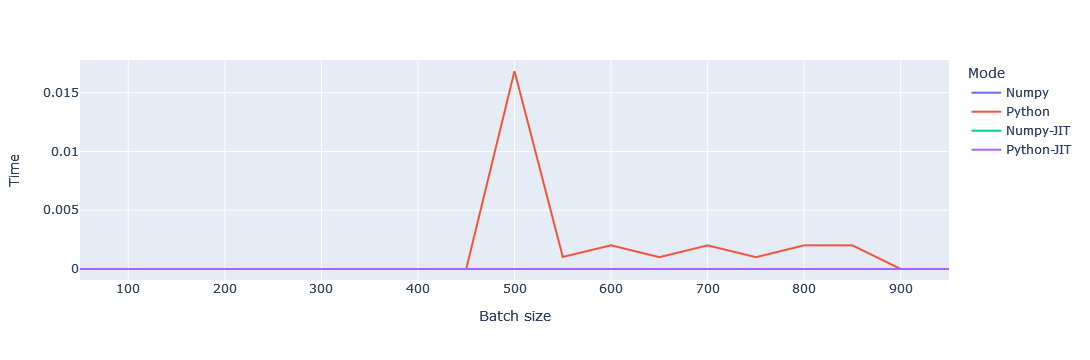

In [156]:
###### Código Aquí ######
df = pd.concat([con_np, sin_np, con_np_jit, sin_np_jit])
#df
px.line(df,x='Batch size', y='Time', color='Mode')
#px.line(sin_np,x='Batch size', y='Time')

**Preguntas**: ¿es posible observar una diferencia? ¿a qué se deberá esto?.

**Respuesta**: Aunque los tiempos obtenidos son bastante pequeños, vemos que Python por si sólo tarda más tiempo que el resto de las opciones que cuentan con optimizaciones al código entre las cuales no se observan diferencias. Esto último puede ser porque el procesador usado es muy poderoso.

Comentamos el gráfico "medicion_tiempos.html" subido a ucursos: Es esperable que la opción Python sea la más lenta puesto que no cuenta con ningún tipo de optimización y utiliza un ciclo for explícito. Luego, Numpy aparece como una opción un poco más rápida porque utiliza la vectorización típica de los métodos Numpy. Por último, las versiones JIT de las opciones anteriores muestran el mejor desempeño con tiempos muy cercanos a 0 aunque como es de esperarse, Numpy-JIT siendo la versión más optimizada, es la más rápida. 


## 1.5 Plot de Resultados [1 Punto]

Llego la hora de visualizar los resultados obtenidos, para esto solo ejecute las siguientes celdas y observe lo que sucede :3. ¿Qué logra observar de los resultados?, ¿La solución resulta trivial?

En esta sección esperamos que solo comenten con lo que logran visualizar de los dataframes.

lower bounds aproximados:

Top 20 post ordenador por el limite inferior:



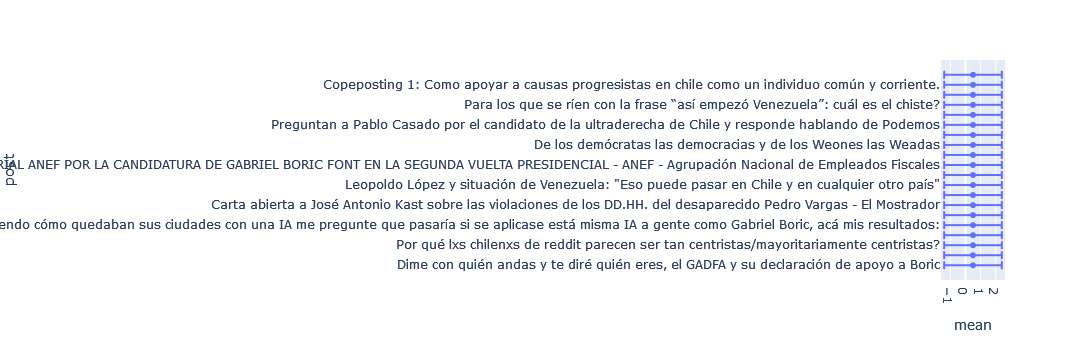

In [157]:
###### Código Aquí ######
votos = votes[len(votes) - 1]
posteo = post[len(post) - 1]
print("lower bounds aproximados:")

#posterior_mean, std_err = intervals_numpy(votos[:, 0], votos[:, 1])
posterior_mean, std_err = mean_std_np(votos)

lb = posterior_mean - std_err
print("\nTop 20 post ordenador por el limite inferior:\n")
order = np.argsort(-lb)
vote_post = {
    'Votos (+)': votos[order[:20], 0],
    'Votos (-)': votos[order[:20], 1],
    'Post': np.array(posteo)[order[:20]],
    'url': np.array(url[len(url) - 1])[order[:20]]
}
df = pd.DataFrame(data=vote_post)
ordered_post = df.Post

r_order = order[::-1][-20:]
data_dic = {
    'mean': posterior_mean[r_order],
    'std_err': std_err[r_order],
    'post': ordered_post[::-1]
}
df = pd.DataFrame(data=data_dic)
fig = px.scatter(df, x="mean", y="post", error_x="std_err")
fig.show()

**Respuesta:**

`Escriba su respuesta aquí`

<p align="center">
  <img src="https://media1.tenor.com/images/fb5bf7cc5a4acb91b4177672886a88ba/tenor.gif?itemid=5591338">
</p>